In [1]:
import sys
sys.path.append("../lib/")
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_val_curves, 
                                     plot_params,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
dataset = "L_540_2022_C_RE"

In [3]:
results_path = Path("../results/") / dataset

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

# Quality Control

In [6]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

,Median Height,N Peaks
count,721.000000,721.000000
mean,521.692556,12.411928
std,430.579917,7.241917
min,0.000000,0.000000
25%,258.361075,6.000000
50%,396.211494,13.000000
75%,658.753355,18.000000
max,4235.953953,28.000000


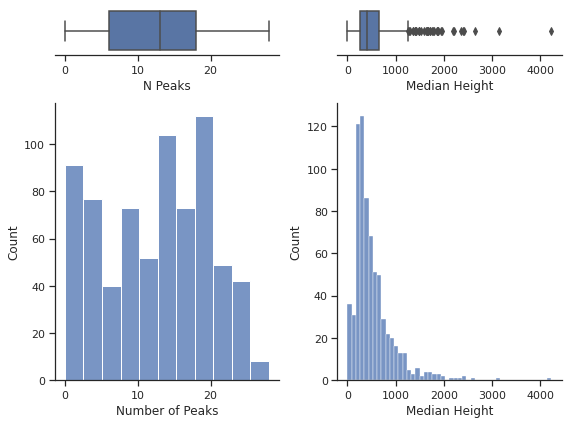

In [7]:
plot_qc_summary(qc_results)

# Dimensionality Reduction
## LDA
### Overview

In [8]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,1.0,0.773825,0.999896,0.717667,0.999896,0.726854,0.395100,0.004245,5.397881e-10
std,0.0,0.019987,0.000185,0.022206,0.000185,0.022021,0.026729,0.001578,1.338073e-09
min,1.0,0.729111,0.999583,0.675000,0.999582,0.681866,0.357810,0.003021,5.729966e-18
25%,1.0,0.763653,0.999896,0.712917,0.999896,0.723210,0.372743,0.003348,1.414013e-14
50%,1.0,0.775278,1.000000,0.720833,1.000000,0.729821,0.389559,0.003917,1.941995e-13
75%,1.0,0.784347,1.000000,0.731250,1.000000,0.740992,0.419207,0.004695,4.219541e-12
max,1.0,0.802111,1.000000,0.760000,1.000000,0.768640,0.435339,0.010172,4.636031e-09


### Confidence scores by class

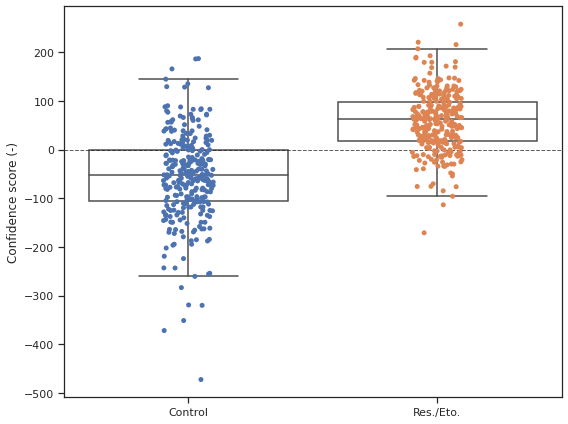

In [9]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

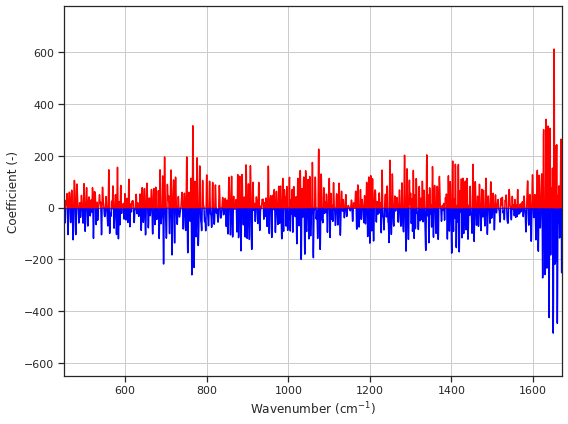

In [10]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)")

### Confusion Matrix

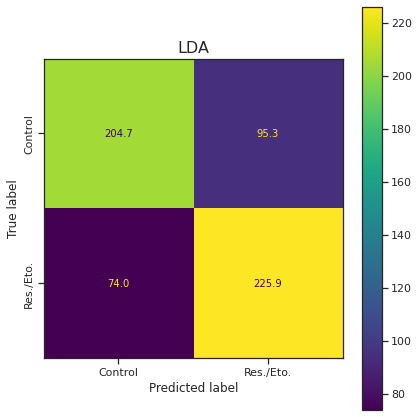

In [11]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

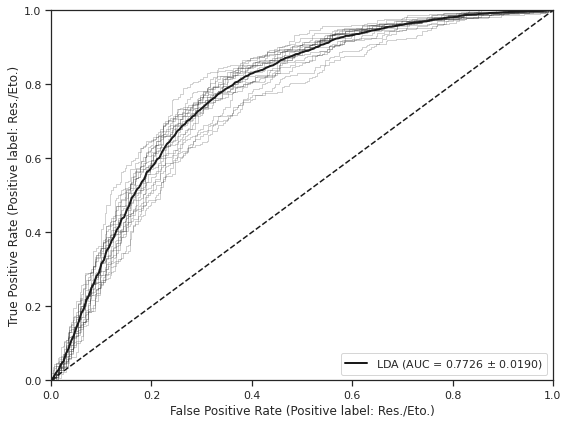

In [12]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## PCA-LDA
### Overview

In [13]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.987927,0.978211,0.945646,0.925250,0.945015,0.924207,2.868836,0.009445,1.365892e-48
std,0.001428,0.001664,0.003487,0.005522,0.003555,0.005825,0.130498,0.001444,3.913485e-48
min,0.985733,0.974556,0.940833,0.915000,0.940324,0.913867,2.708435,0.007740,5.063014e-52
25%,0.986723,0.977444,0.943646,0.921250,0.942809,0.919560,2.736280,0.008087,1.102835e-50
50%,0.988125,0.978667,0.944792,0.925833,0.944176,0.924741,2.883047,0.008958,1.032156e-49
75%,0.988614,0.979181,0.947604,0.928750,0.946650,0.928757,2.963950,0.010710,2.787026e-49
max,0.990611,0.981389,0.953333,0.936667,0.952996,0.936549,3.116257,0.012339,1.436236e-47


### Validation Curve

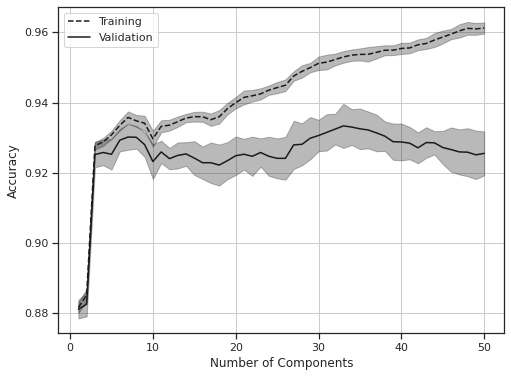

In [14]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Components", y_label="Accuracy")

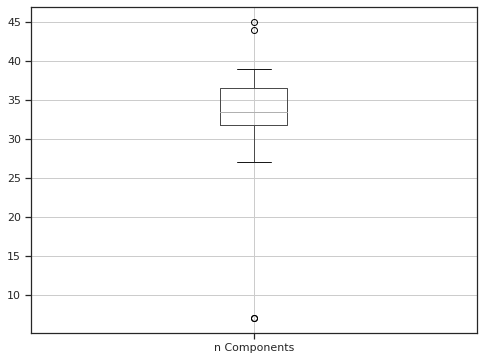

In [15]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

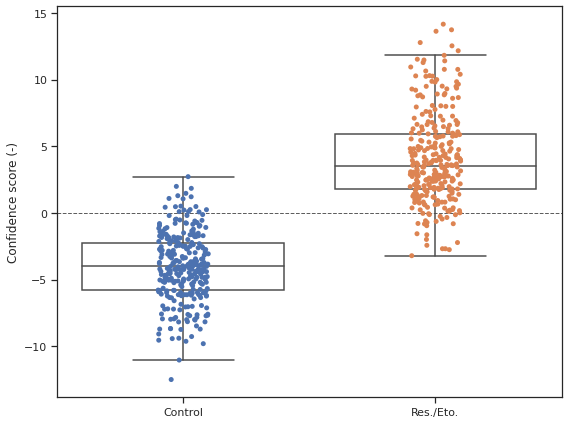

In [16]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

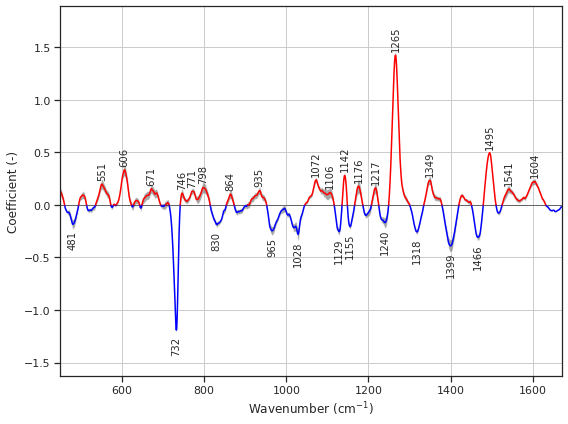

In [17]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

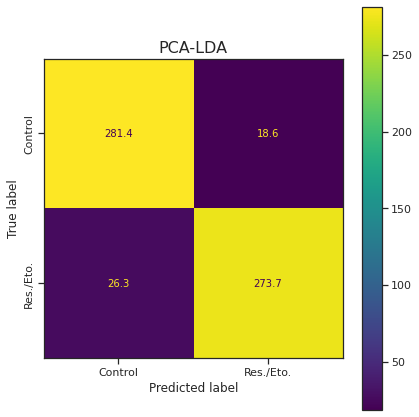

In [18]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

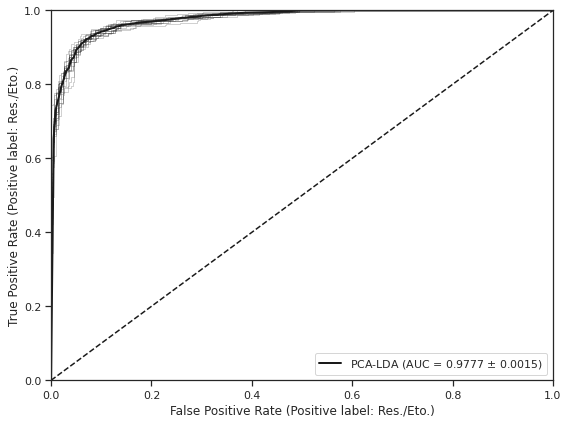

In [19]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## NMF-LDA
### Overview

In [20]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.983930,0.977661,0.932104,0.916000,0.930676,0.913803,10.997557,0.016908,6.897379e-48
std,0.001469,0.002636,0.005088,0.006361,0.005356,0.007022,0.209618,0.002775,1.578321e-47
min,0.981424,0.969944,0.925833,0.901667,0.923817,0.897510,10.595838,0.012001,9.944852e-51
25%,0.983145,0.977181,0.928542,0.911667,0.926880,0.909854,10.832384,0.015861,1.128849e-49
50%,0.983687,0.977778,0.930833,0.916667,0.929249,0.914293,11.004859,0.016595,4.001385e-49
75%,0.985055,0.979486,0.935625,0.921667,0.934707,0.919658,11.173796,0.018922,1.296124e-48
max,0.986441,0.980778,0.943333,0.925000,0.942118,0.924356,11.355783,0.022012,6.390125e-47


### Validation Curve

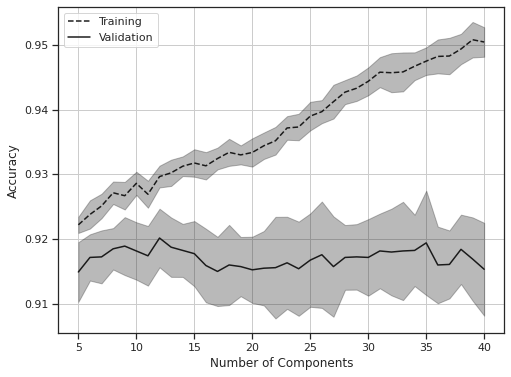

In [21]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Components", y_label="Accuracy")

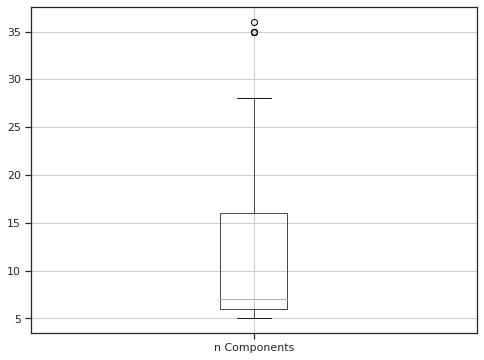

In [22]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

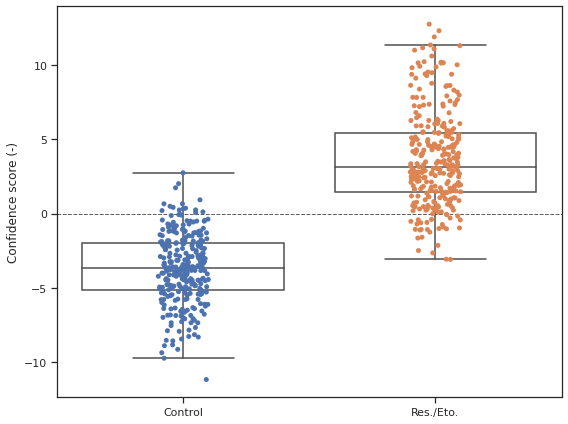

In [23]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

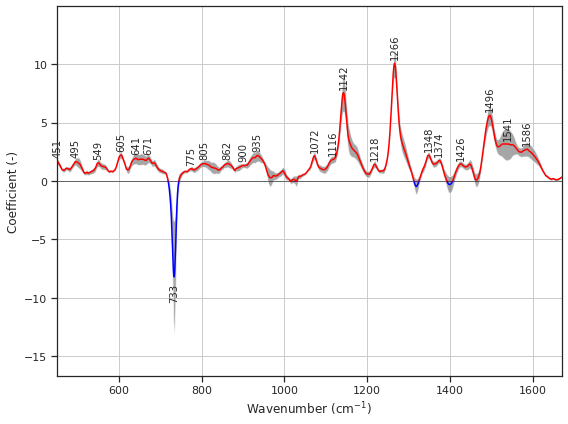

In [24]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

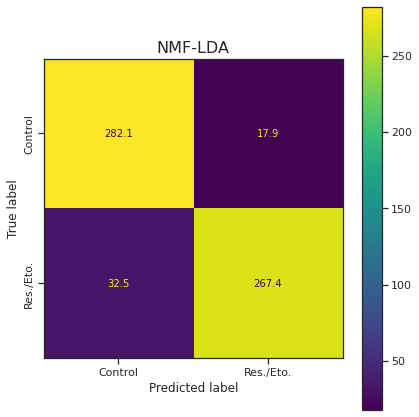

In [25]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

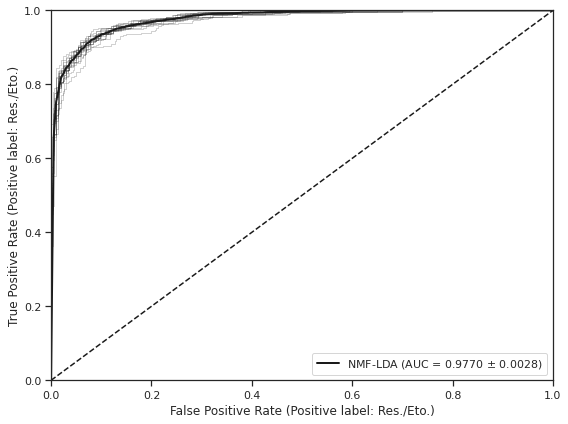

In [26]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Feature Agglomeration (FA) - LDA
### Overview

In [27]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.985300,0.978053,0.937438,0.921667,0.936372,0.920184,6.132868,0.006418,1.132221e-46
std,0.001524,0.002920,0.004252,0.007590,0.004421,0.007854,0.083986,0.000444,4.962513e-46
min,0.982222,0.972722,0.929583,0.905000,0.928550,0.902687,6.011895,0.006103,1.642697e-52
25%,0.984503,0.976111,0.935312,0.917917,0.934384,0.915802,6.064945,0.006135,6.916911e-51
50%,0.985323,0.978583,0.937708,0.923333,0.936479,0.921843,6.121266,0.006227,8.186647e-50
75%,0.986232,0.980250,0.939896,0.927083,0.938943,0.925504,6.173301,0.006412,4.110252e-48
max,0.988361,0.982611,0.945417,0.933333,0.944835,0.933015,6.366276,0.007551,2.221489e-45


### Validation Curve

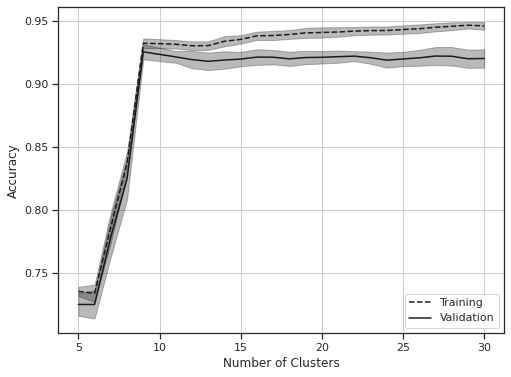

In [28]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Clusters", y_label="Accuracy")

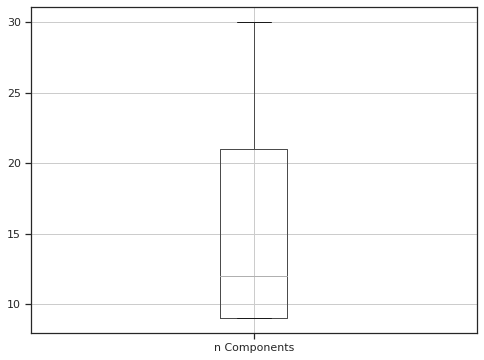

In [29]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

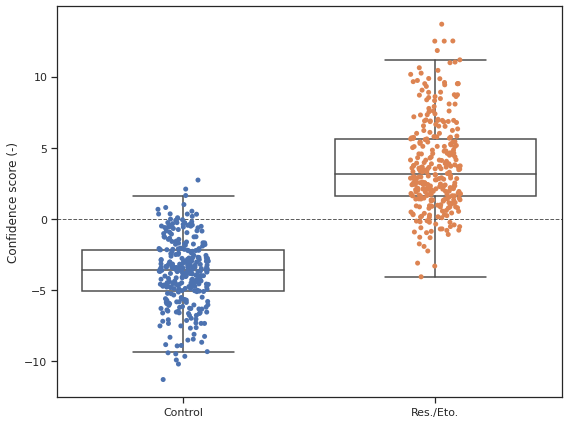

In [30]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

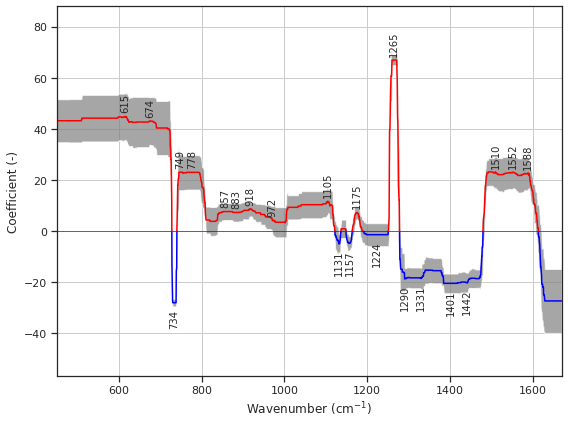

In [31]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

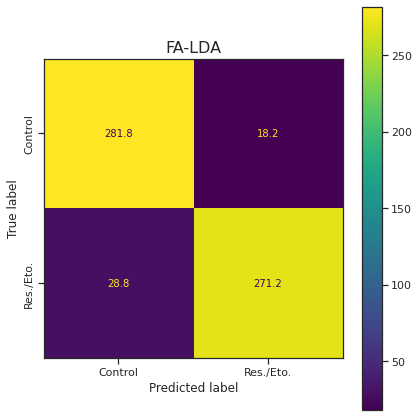

In [32]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

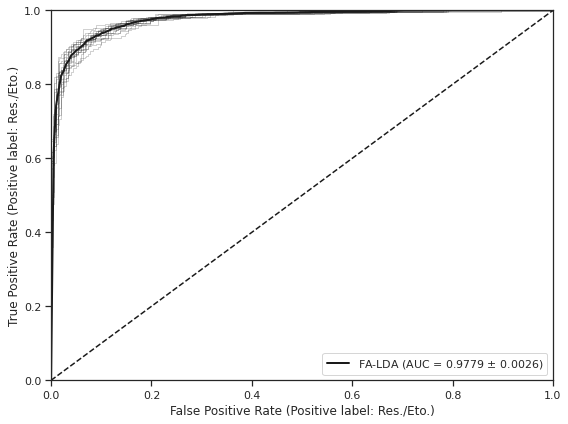

In [33]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Peak-LDA
### Overview

In [34]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.994108,0.989883,0.961396,0.948750,0.960638,0.947606,0.402687,0.002844,2.966762e-55
std,0.000237,0.001379,0.001738,0.005458,0.001782,0.005629,0.022804,0.000170,6.843772e-55
min,0.993708,0.986722,0.958333,0.941667,0.957497,0.939828,0.340399,0.002585,1.863896e-59
25%,0.993964,0.989111,0.960833,0.944583,0.960020,0.943428,0.396343,0.002713,5.093964e-57
50%,0.994082,0.989944,0.961250,0.947500,0.960462,0.946260,0.401849,0.002837,6.616182e-56
75%,0.994207,0.990750,0.962500,0.953333,0.961789,0.952303,0.414221,0.002959,2.434263e-55
max,0.994660,0.992278,0.965000,0.960000,0.964301,0.959030,0.448477,0.003210,3.064999e-54


### Validation Curve

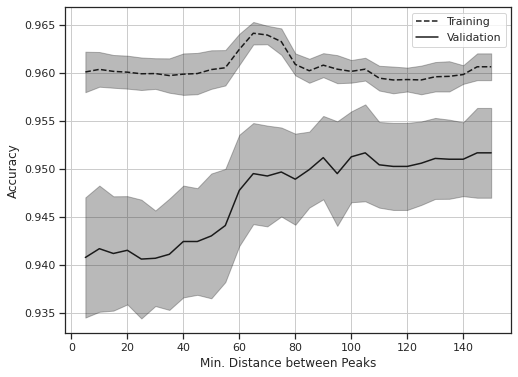

In [35]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Min. Distance between Peaks", y_label="Accuracy")

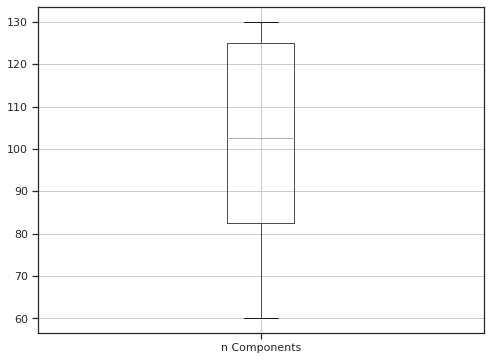

In [36]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

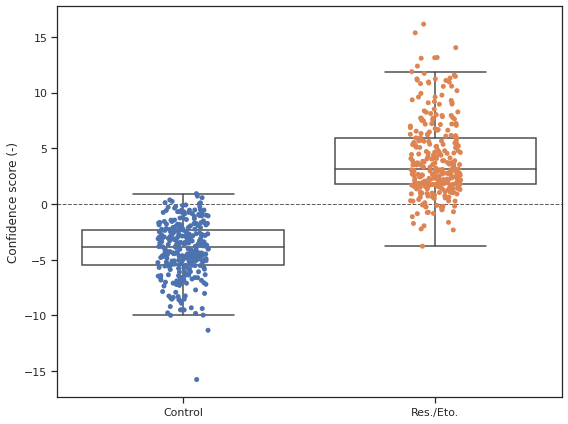

In [37]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

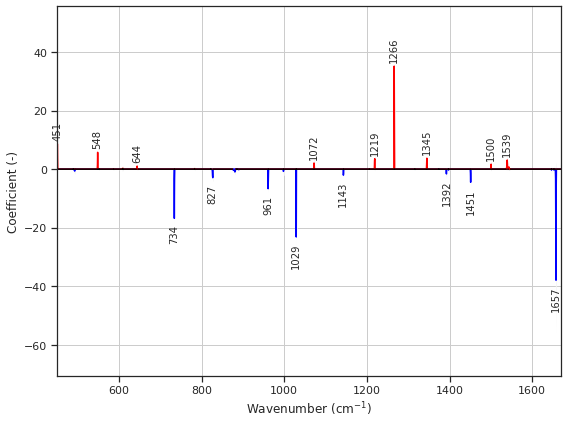

In [38]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

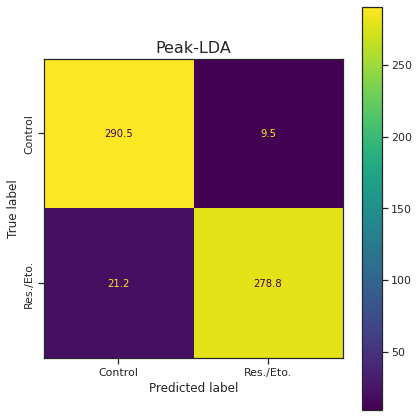

In [39]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

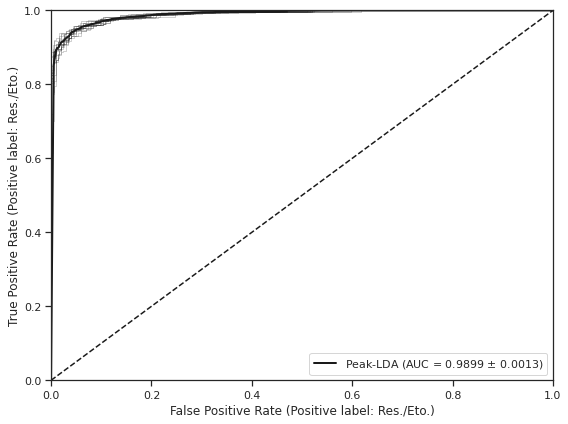

In [40]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Comparison of LDA with different dimensionality Reductions

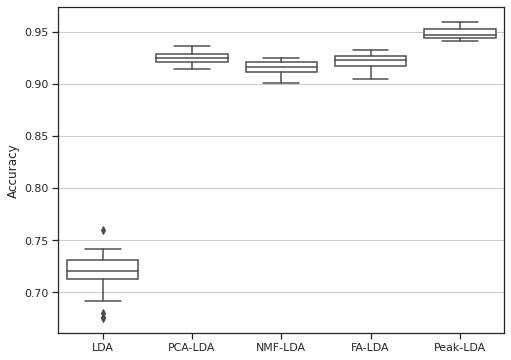

In [41]:
boxplot_comparison(accs, ylabel="Accuracy")

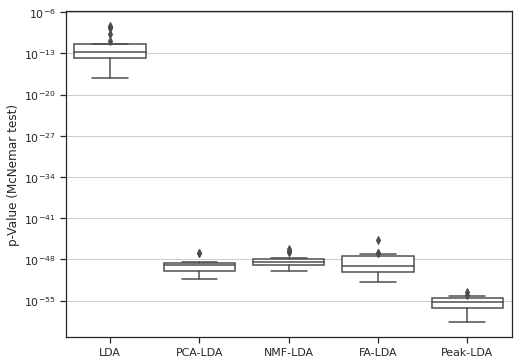

In [42]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True)

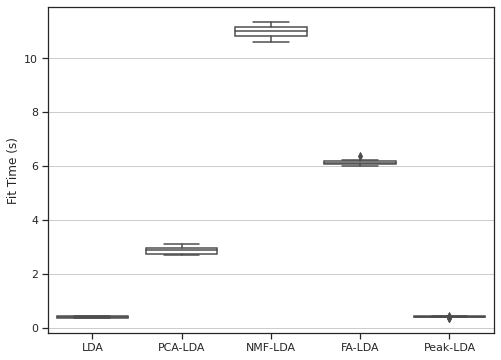

In [43]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)")

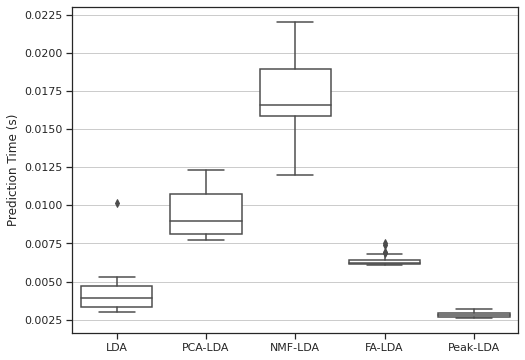

In [44]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)")

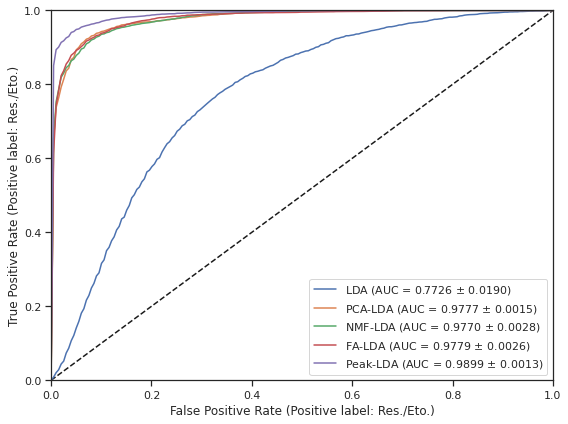

In [45]:
plot_roc_comparison(rocs, aucs, labels=y_key)

# Regularized Models
## Logistic Regression (l1)
### Overview

In [46]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.998829,0.993328,0.986604,0.955417,0.986413,0.954511,1.798481,0.008722,5.285063e-56
std,0.000596,0.001176,0.003876,0.004648,0.003959,0.004728,0.028720,0.000987,1.810296e-55
min,0.997694,0.991667,0.981667,0.945000,0.981443,0.944113,1.743775,0.007610,6.841374e-60
25%,0.998444,0.992694,0.983229,0.953333,0.982982,0.951956,1.775265,0.007978,1.641727e-58
50%,0.998780,0.993111,0.985625,0.955833,0.985409,0.954897,1.803685,0.008435,1.692413e-57
75%,0.999293,0.993931,0.989479,0.956667,0.989362,0.956461,1.818801,0.009176,5.207253e-57
max,0.999760,0.996056,0.993333,0.963333,0.993314,0.962482,1.838344,0.011572,8.097859e-55


### Validation Curve

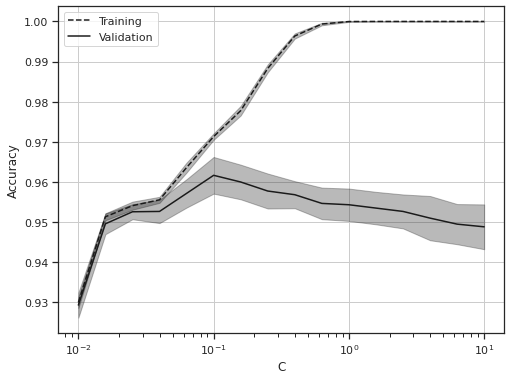

In [47]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

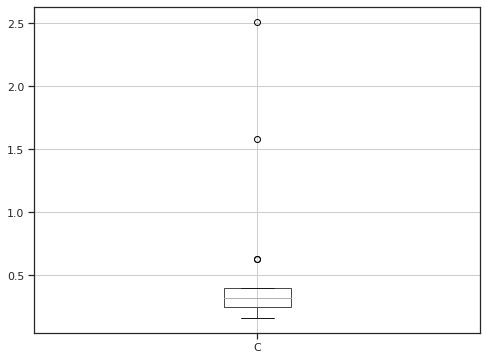

In [48]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="C")

### Confidence scores by class

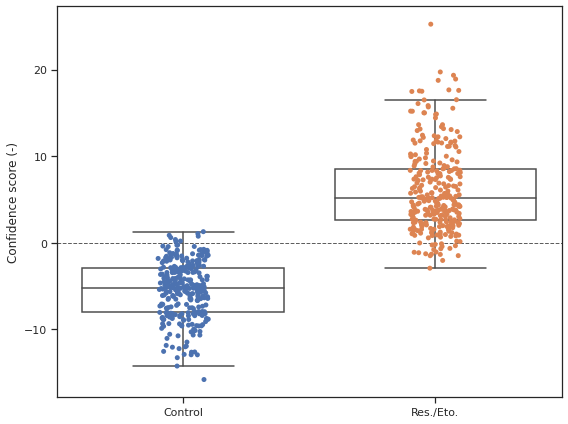

In [49]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

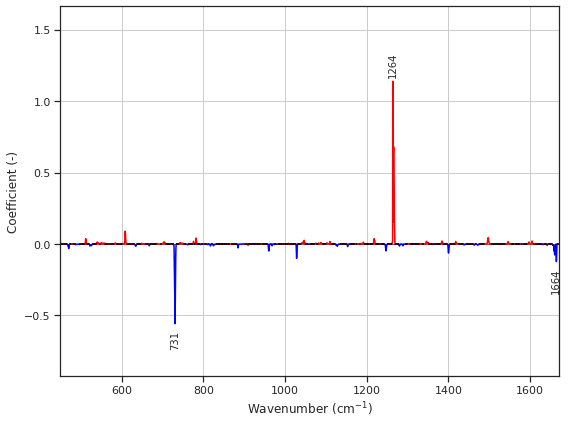

In [50]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

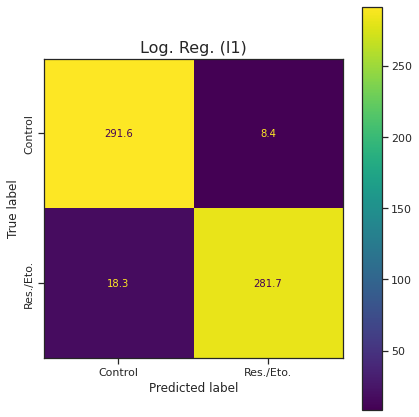

In [51]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

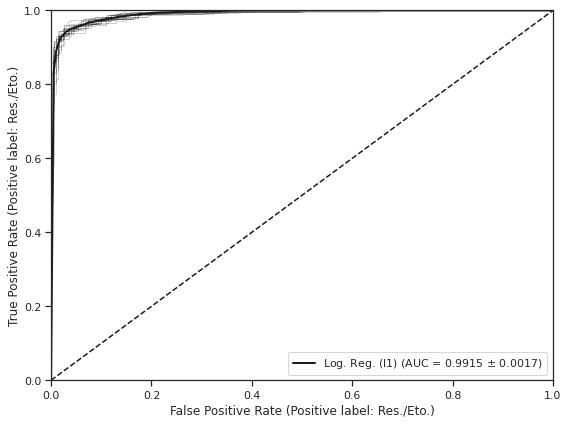

In [52]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Logistic Regression (l2)
### Overview

In [53]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.999562,0.980822,0.993312,0.926500,0.993276,0.925620,2.147387,0.007695,9.825938e-48
std,0.000357,0.002500,0.003021,0.007664,0.003045,0.007736,0.044298,0.000894,3.527385e-47
min,0.998691,0.977111,0.987917,0.911667,0.987818,0.910877,2.081529,0.006384,5.090754e-53
25%,0.999438,0.978653,0.990417,0.920833,0.990359,0.919777,2.114682,0.007081,2.402767e-51
50%,0.999660,0.981639,0.993750,0.927500,0.993732,0.926042,2.141187,0.007685,7.354752e-50
75%,0.999806,0.981944,0.995104,0.931667,0.995088,0.930444,2.173125,0.007848,9.692786e-49
max,1.000000,0.986056,0.999583,0.941667,0.999582,0.941544,2.235522,0.009868,1.579283e-46


### Validation Curve

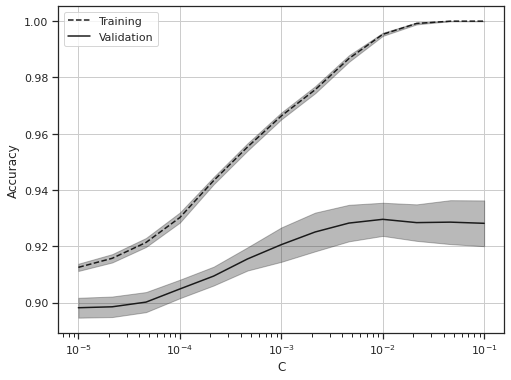

In [54]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

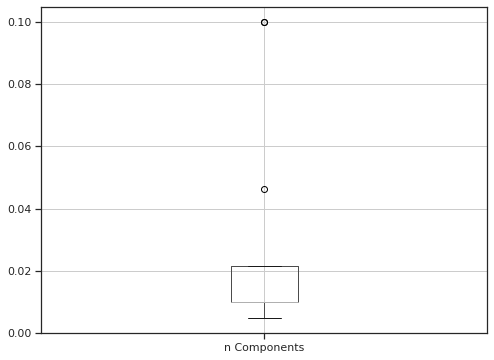

In [55]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

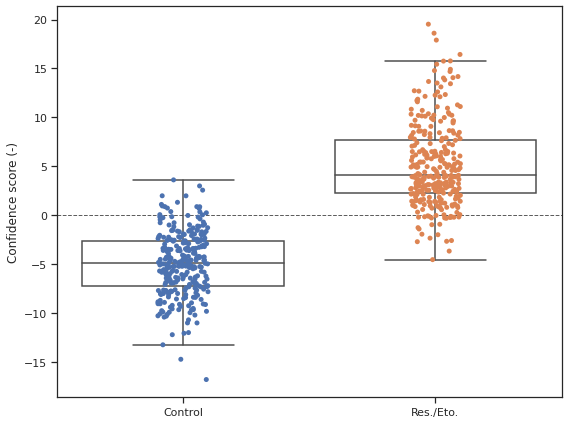

In [56]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

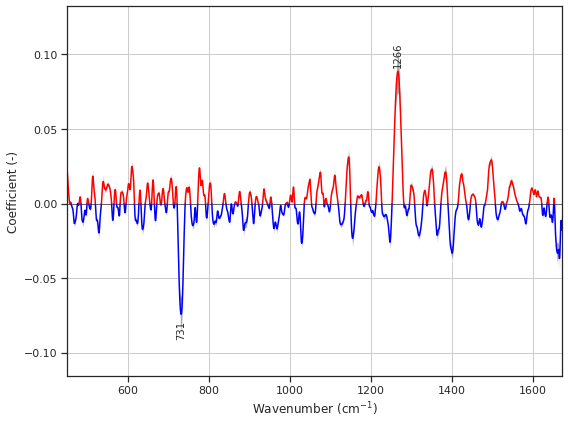

In [57]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.05, min_dist=50)

### Confusion Matrix

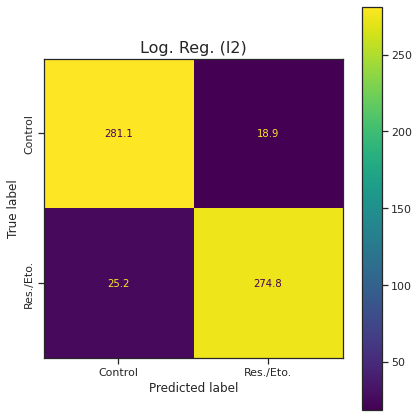

In [58]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

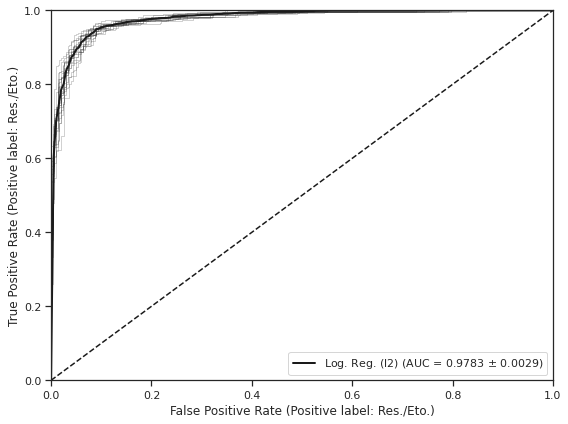

In [59]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l1)
### Overview

In [60]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.998634,0.993450,0.983625,0.955000,0.983380,0.954077,3.438104,0.008734,7.719650e-54
std,0.000516,0.001112,0.003211,0.005593,0.003279,0.005596,0.084405,0.000611,3.450264e-53
min,0.997444,0.991000,0.977083,0.938333,0.976760,0.937824,3.283552,0.007581,4.144818e-60
25%,0.998401,0.992917,0.981771,0.951667,0.981451,0.950497,3.366360,0.008384,3.163566e-58
50%,0.998738,0.993361,0.983542,0.956667,0.983297,0.955496,3.441347,0.008731,1.026294e-57
75%,0.998897,0.994014,0.985625,0.956667,0.985421,0.955960,3.500130,0.009278,4.793623e-57
max,0.999323,0.996167,0.990417,0.965000,0.990298,0.963841,3.581979,0.009686,1.543051e-52


### Validation Curve

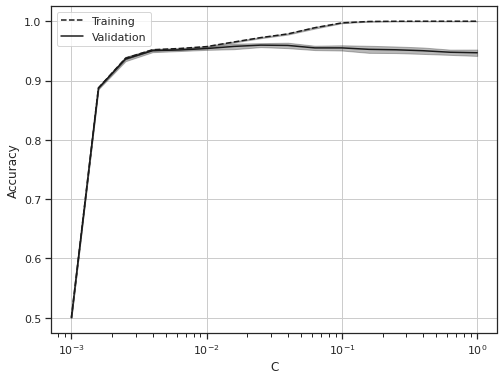

In [61]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

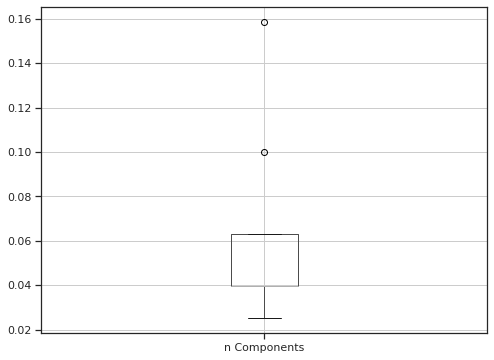

In [62]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

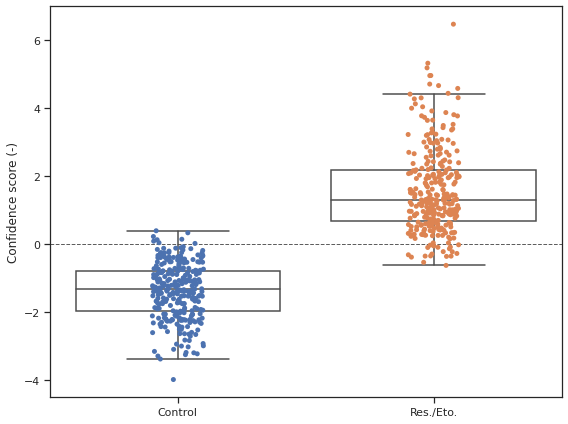

In [63]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

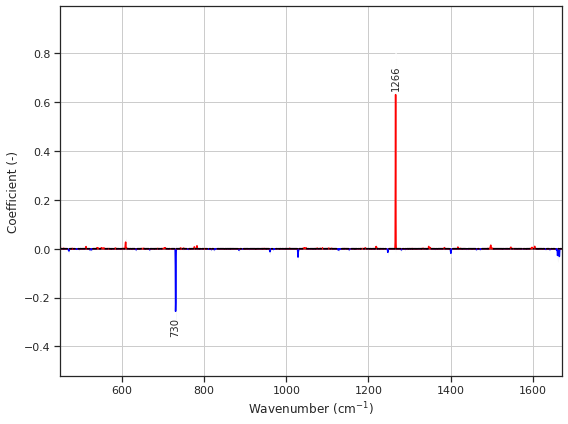

In [64]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

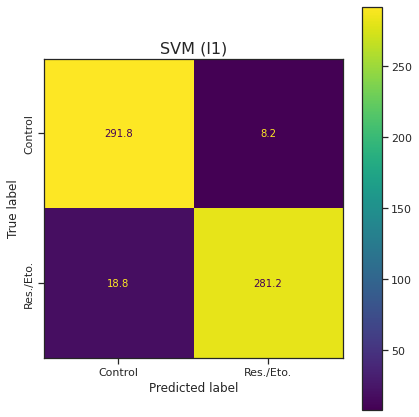

In [65]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

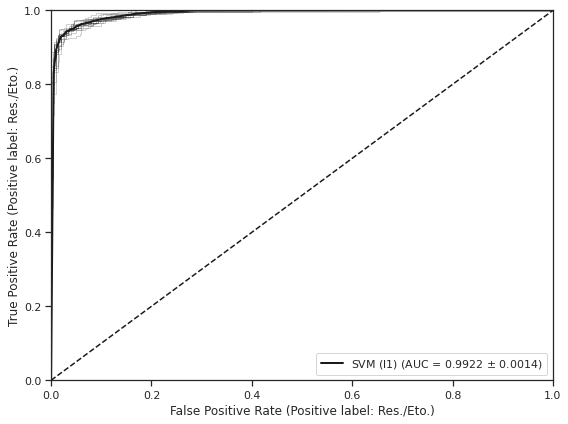

In [66]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l2)
### Overview

In [67]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.999290,0.980725,0.989771,0.923917,0.989715,0.923147,1.707909,0.007630,1.903913e-47
std,0.000551,0.002923,0.004599,0.007097,0.004640,0.007169,0.065993,0.000665,7.026435e-47
min,0.997556,0.976389,0.976667,0.911667,0.976458,0.911096,1.620945,0.006818,5.560773e-52
25%,0.999141,0.978194,0.987917,0.918333,0.987854,0.917417,1.646971,0.007220,2.043550e-50
50%,0.999342,0.980889,0.989167,0.924167,0.989120,0.923373,1.705315,0.007370,8.055932e-49
75%,0.999695,0.983042,0.992188,0.928750,0.992124,0.928368,1.754783,0.007986,3.247849e-48
max,0.999944,0.985667,0.998333,0.936667,0.998326,0.936192,1.832409,0.008963,3.161418e-46


### Validation Curve

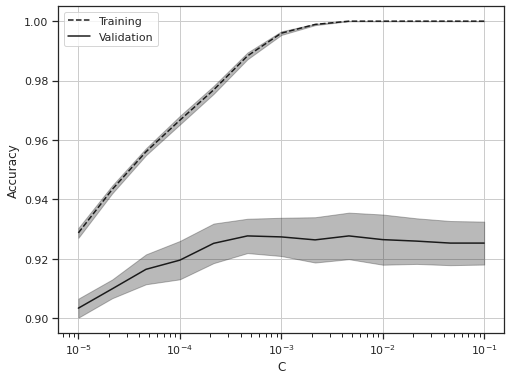

In [68]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

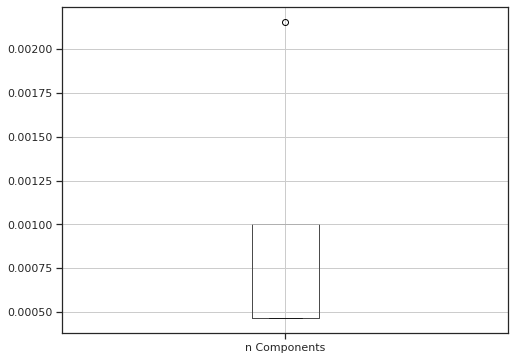

In [69]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="n Components")

### Confidence scores by class

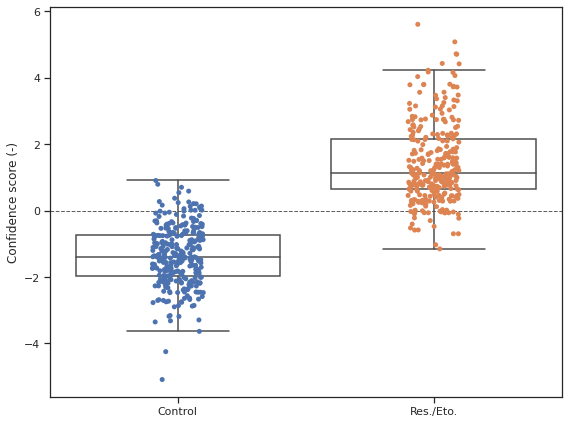

In [70]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

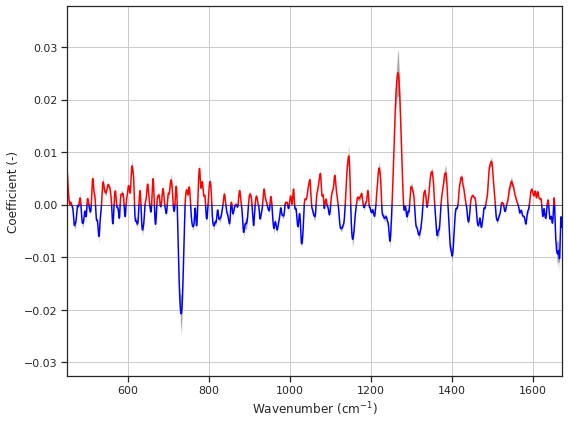

In [71]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

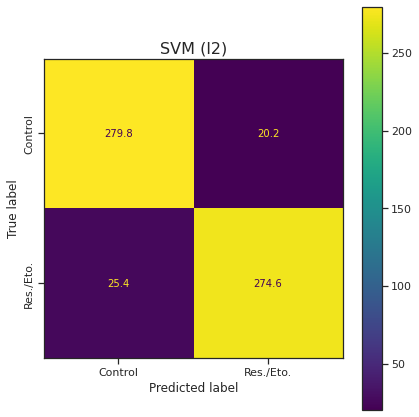

In [72]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

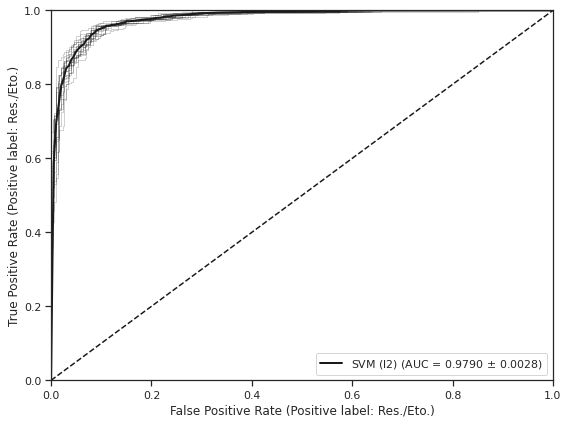

In [73]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

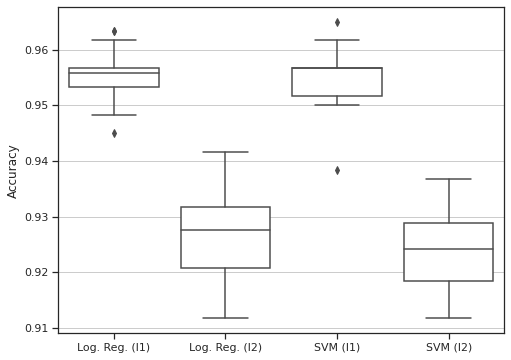

In [74]:
boxplot_comparison(accs, ylabel="Accuracy", regex="Log. Reg.|SVM")

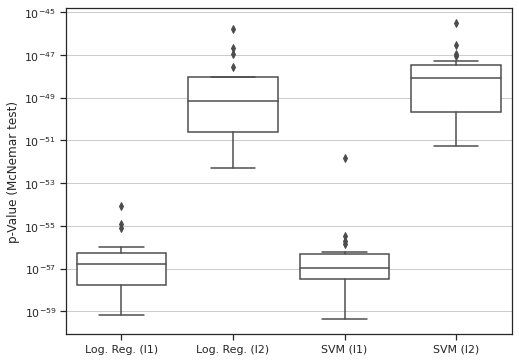

In [75]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True, regex="Log. Reg.|SVM")

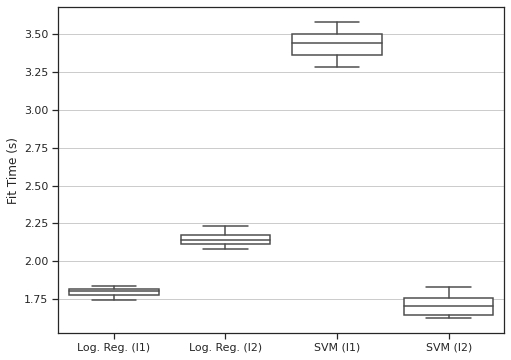

In [76]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)", regex="Log. Reg.|SVM")

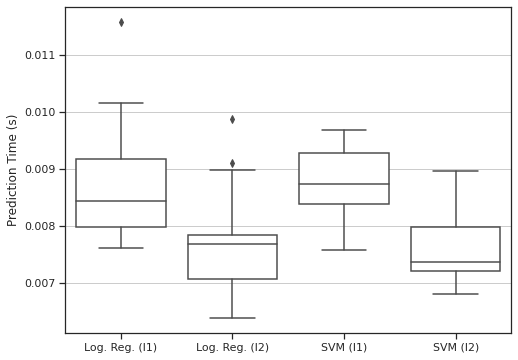

In [77]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)", regex="Log. Reg.|SVM")

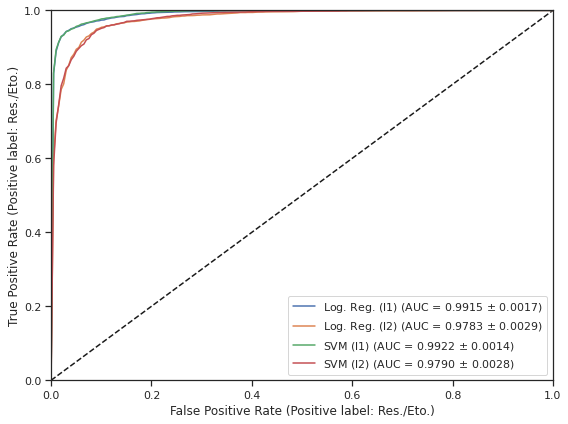

In [78]:
plot_roc_comparison(rocs, aucs, labels=y_key, regex="Log. Reg.|SVM")

## Decision Tree
### Overview

In [89]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.968126,0.935851,0.947542,0.910917,0.947682,0.910974,6.074693,0.004849,1.788566e-43
std,0.003744,0.009288,0.004127,0.005760,0.003977,0.005937,0.071843,0.000433,3.826441e-43
min,0.963005,0.912333,0.940417,0.895000,0.940036,0.894189,5.952633,0.004081,2.603858e-48
25%,0.964018,0.930187,0.944583,0.909167,0.945001,0.908809,6.031545,0.004611,2.217628e-46
50%,0.968122,0.936917,0.948125,0.911667,0.948238,0.911924,6.086317,0.004808,1.938955e-45
75%,0.970565,0.944257,0.950104,0.915000,0.950298,0.914711,6.118520,0.005039,1.880208e-44
max,0.975432,0.946083,0.955000,0.920000,0.954187,0.919824,6.177205,0.005782,1.200803e-42


### Validation Curve

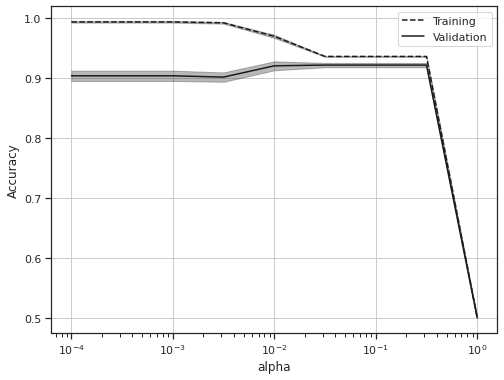

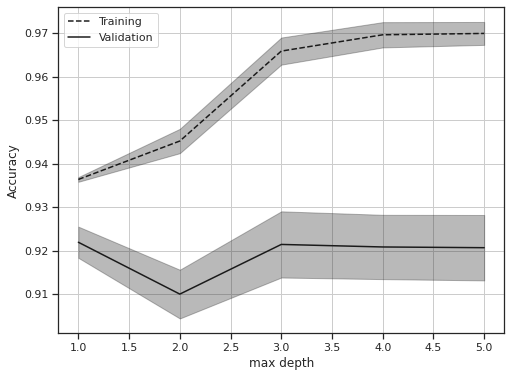

In [90]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels=["alpha", "max depth"], y_label="Accuracy", log_scale=[True, False])

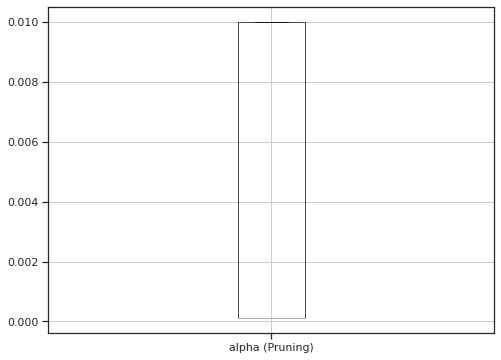

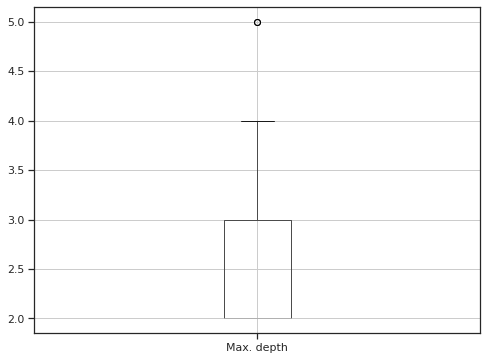

In [81]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels=["alpha (Pruning)", "Max. depth"])

### Confidence scores by class

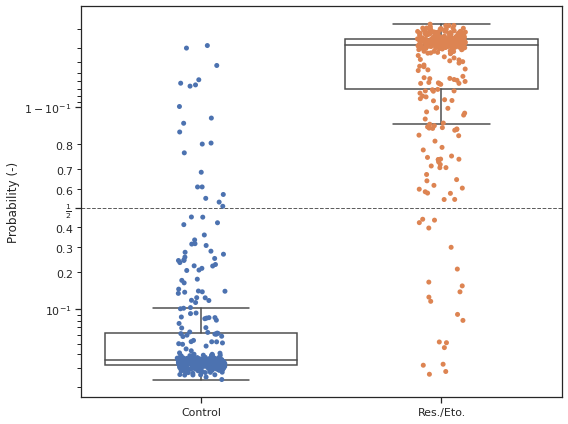

In [82]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Tree

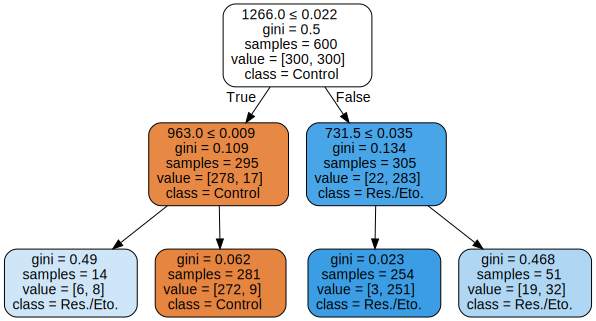

In [83]:
graphviz.Source.from_file(current_path / "tree.dot")

### Confusion Matrix

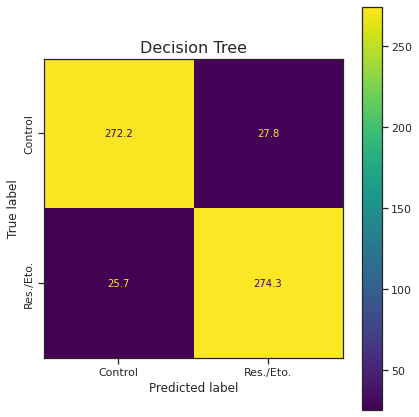

In [84]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

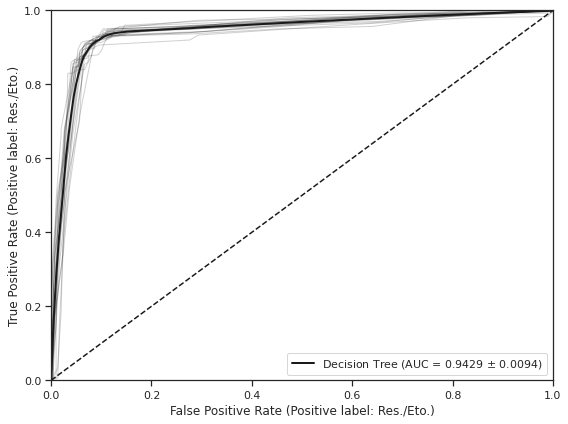

In [85]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Random Forest
### Overview

In [92]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.995895,0.986083,0.966229,0.939667,0.965919,0.938875,9.842747,0.005783,3.041618e-52
std,0.000528,0.001298,0.002882,0.004543,0.002929,0.004704,0.127079,0.003496,7.429463e-52
min,0.994962,0.983389,0.961667,0.931667,0.961325,0.930836,9.710707,0.004239,3.479322e-55
25%,0.995591,0.985028,0.964896,0.936250,0.964562,0.935364,9.761915,0.004627,6.487130e-54
50%,0.995880,0.986250,0.965833,0.940000,0.965554,0.939489,9.802555,0.004728,2.229188e-53
75%,0.996253,0.987042,0.967708,0.942083,0.967433,0.941730,9.898225,0.004880,1.048767e-52
max,0.996861,0.988611,0.972083,0.946667,0.971863,0.946326,10.255383,0.018784,2.455615e-51


### Validation Curve

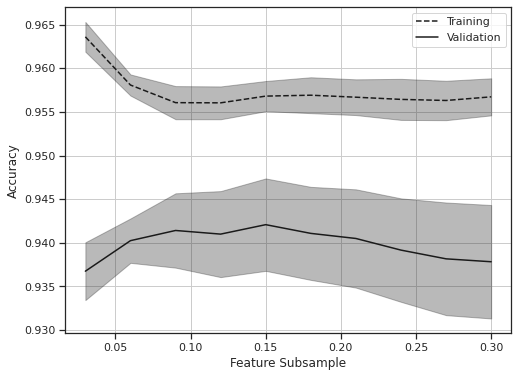

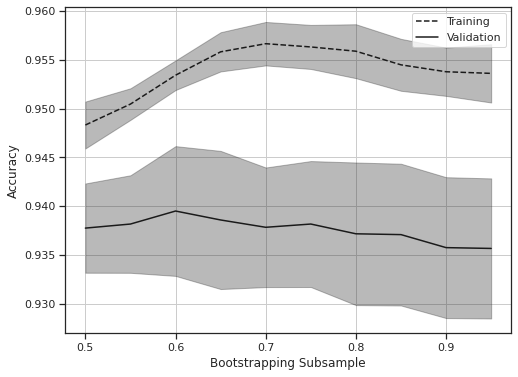

In [94]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels=["Feature Subsample", "Bootstrapping Subsample"], y_label="Accuracy")

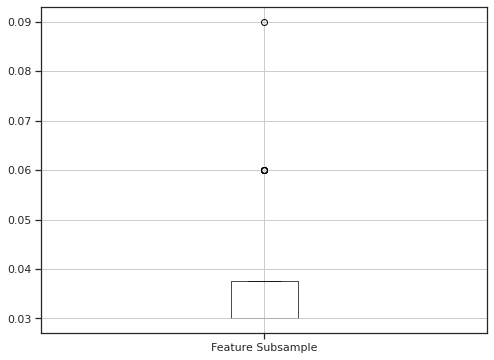

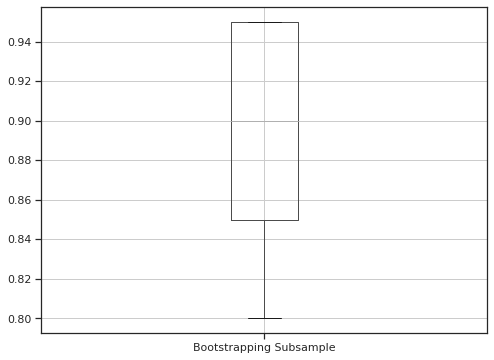

In [96]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels=["Feature Subsample", "Bootstrapping Subsample"])

### Confidence scores by class

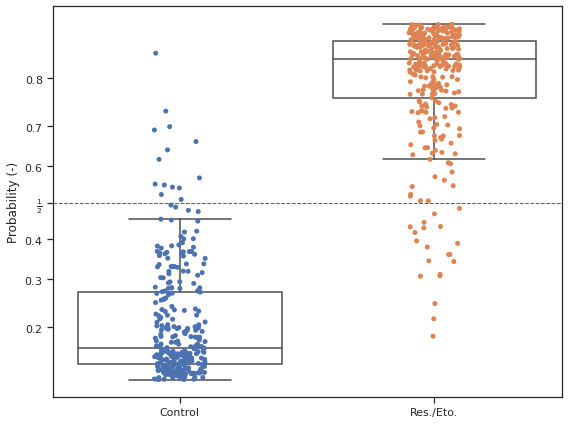

In [ ]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Confusion Matrix

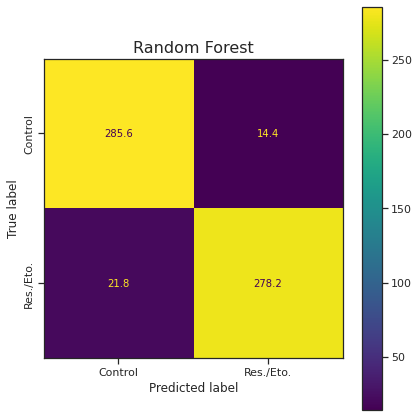

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

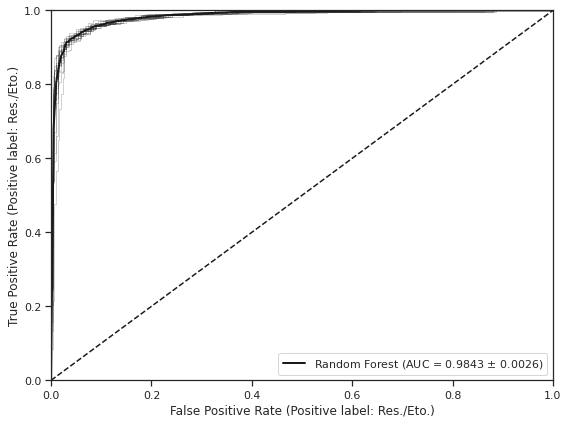

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [ ]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

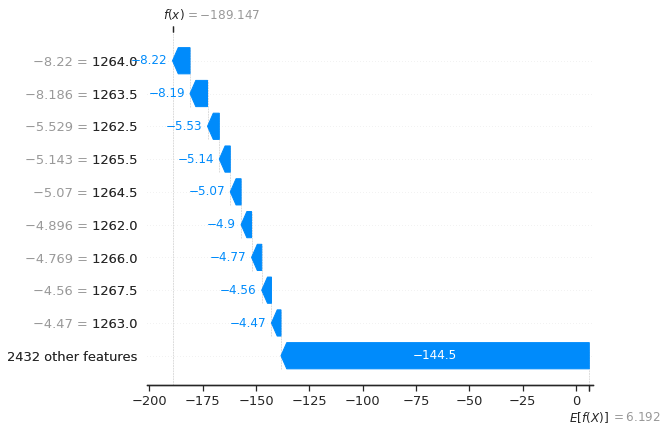

In [ ]:
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

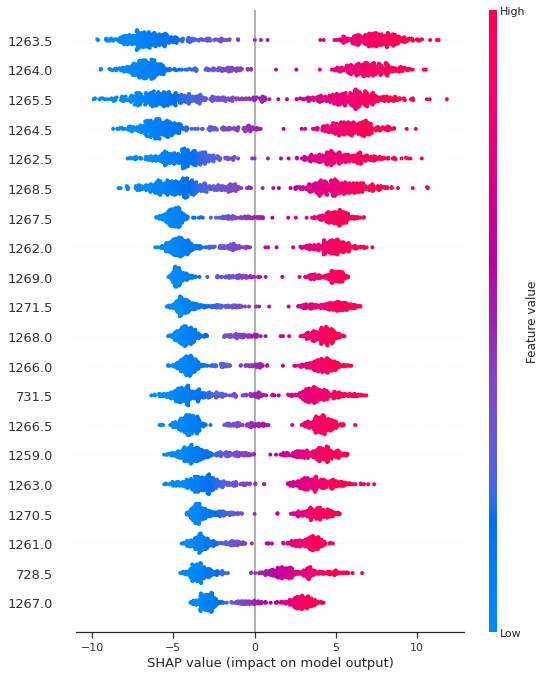

In [ ]:
shap.summary_plot(explanation, feature_names=shap_features)

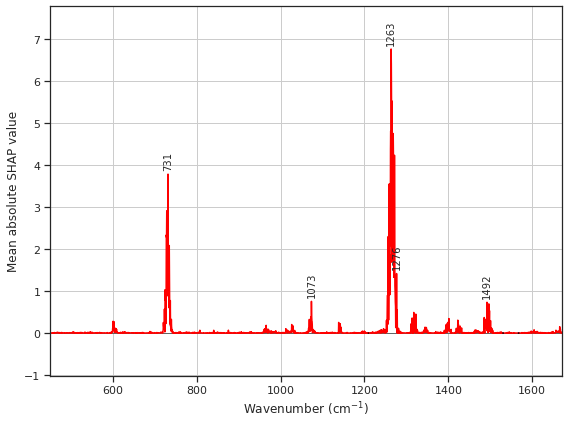

In [ ]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

plot_coefs(shap_val_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", ylabel="Mean absolute SHAP value", annotate=True, min_height=0.5)

## Gradient Boosted Trees
### Overview

In [97]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boosted Trees"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.0,20.000000,20.0,20.000000,20.0,20.000000,20.000000,20.000000,2.000000e+01
mean,1.0,0.990628,1.0,0.953417,1.0,0.953072,1.605416,0.004881,5.263133e-55
std,0.0,0.001245,0.0,0.004375,0.0,0.004439,0.121028,0.001790,1.173219e-54
min,1.0,0.988611,1.0,0.945000,1.0,0.944506,1.495972,0.004232,3.163566e-58
25%,1.0,0.989792,1.0,0.950000,1.0,0.949652,1.531520,0.004286,1.683461e-56
50%,1.0,0.990250,1.0,0.953333,1.0,0.953326,1.552400,0.004346,6.701296e-56
75%,1.0,0.991681,1.0,0.956667,1.0,0.956190,1.616613,0.004706,2.407968e-55
max,1.0,0.993389,1.0,0.963333,1.0,0.963241,1.920803,0.012357,4.238649e-54


### Validation Curve

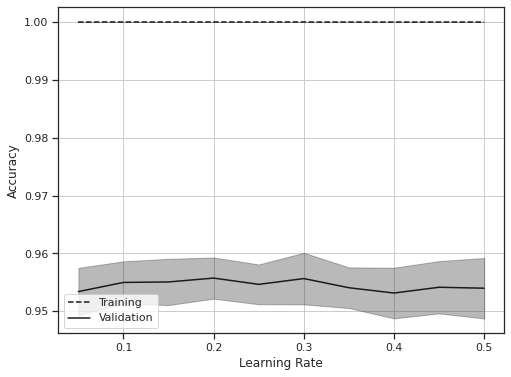

In [98]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Learning Rate", y_label="Accuracy")

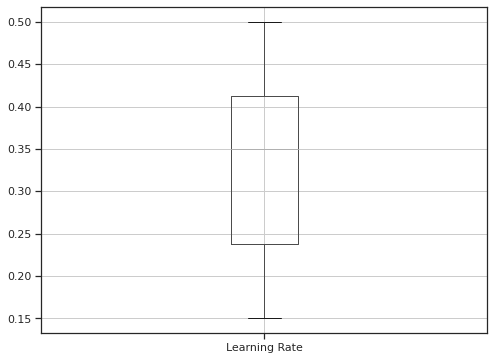

In [99]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Learning Rate")

### Confidence scores by class

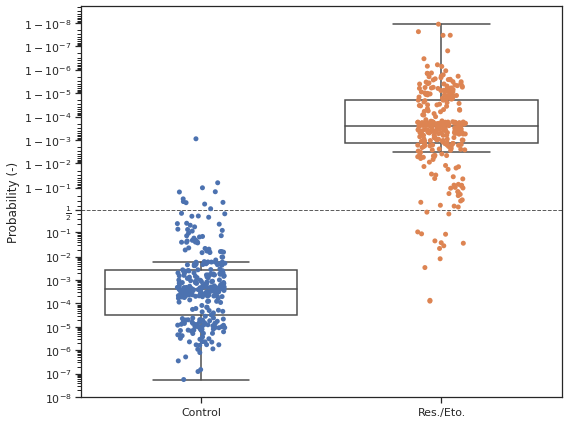

In [100]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Confusion Matrix

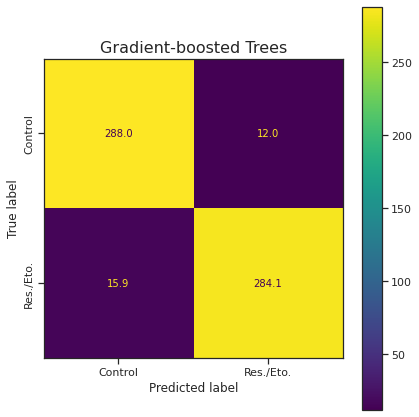

In [101]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

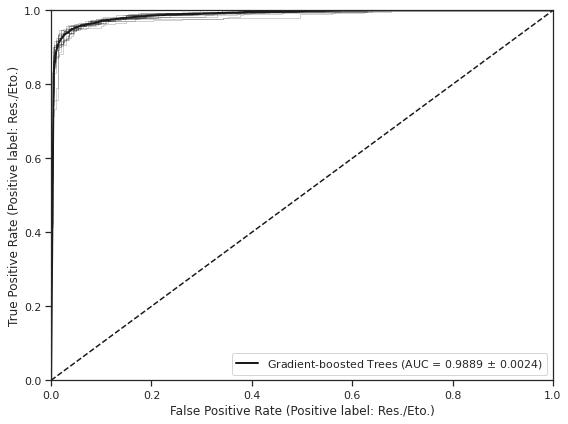

In [102]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [103]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

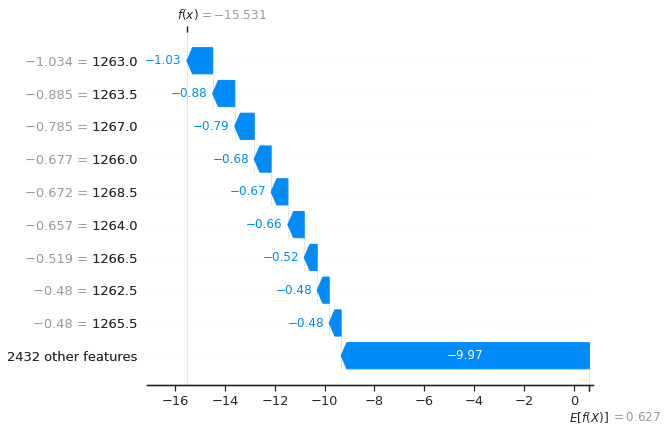

In [104]:
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

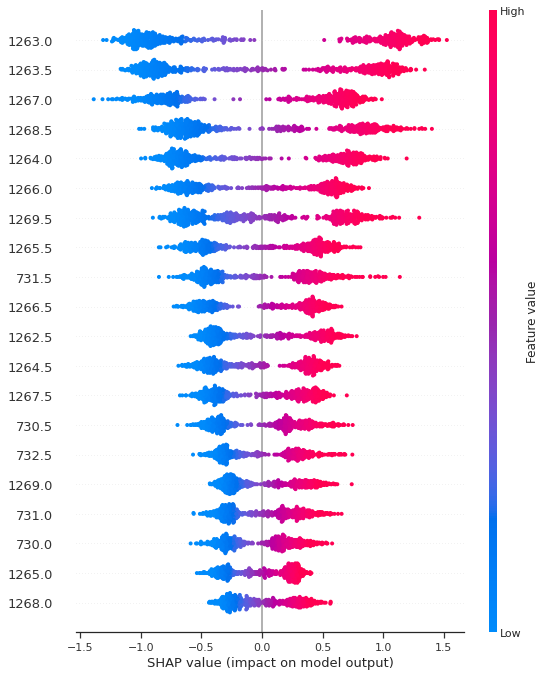

In [105]:
shap.summary_plot(explanation, feature_names=shap_features)

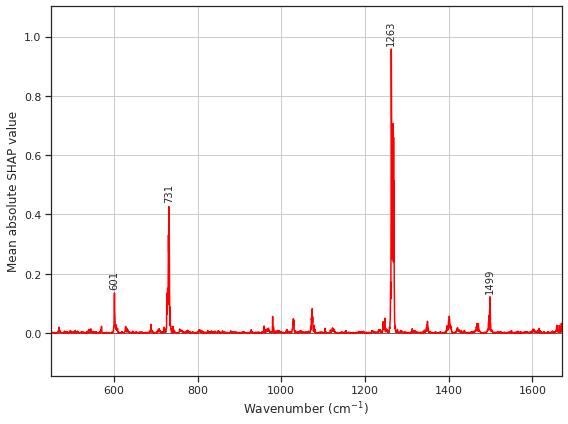

In [107]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

plot_coefs(shap_val_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", ylabel="Mean absolute SHAP value", annotate=True, min_height=0.1)

## Comparison of Tree-based Models

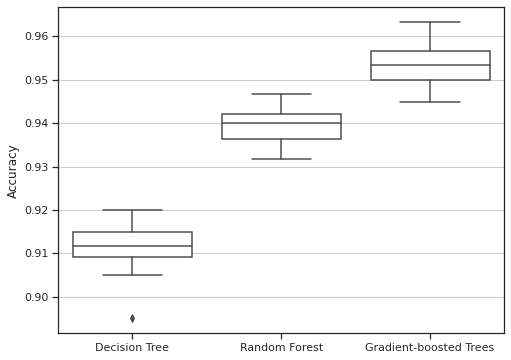

In [ ]:
boxplot_comparison(accs, ylabel="Accuracy", regex="Tree|Forest")

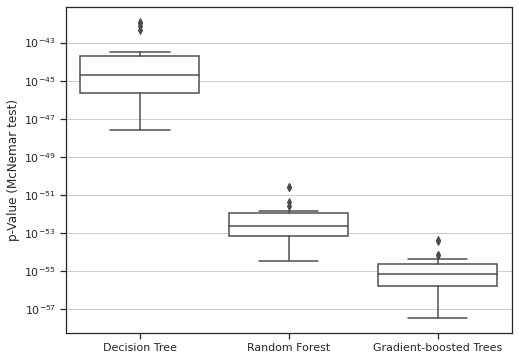

In [ ]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True, regex="Tree|Forest")

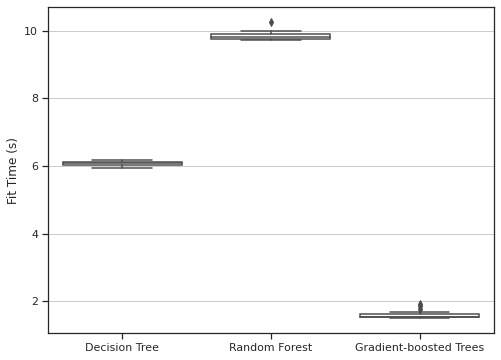

In [ ]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)", regex="Tree|Forest")

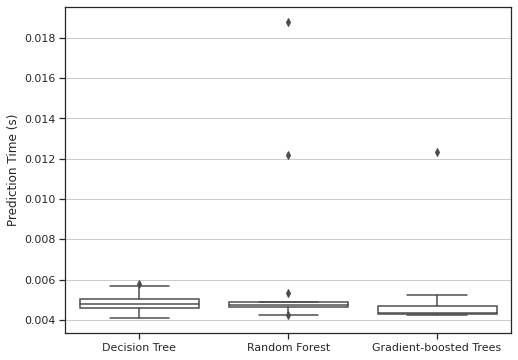

In [ ]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)", regex="Tree|Forest")

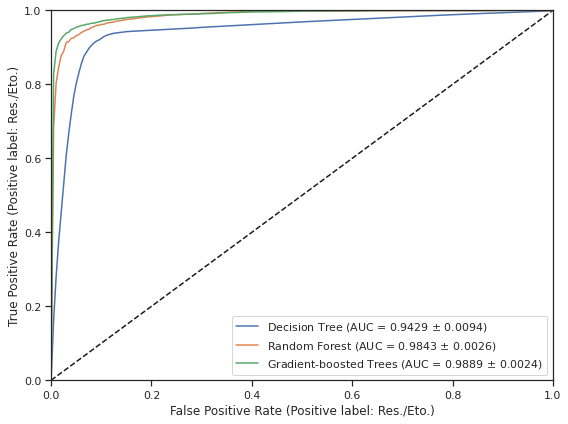

In [ ]:
plot_roc_comparison(rocs, aucs, labels=y_key, regex="Tree|Forest")

## Overall Comparison

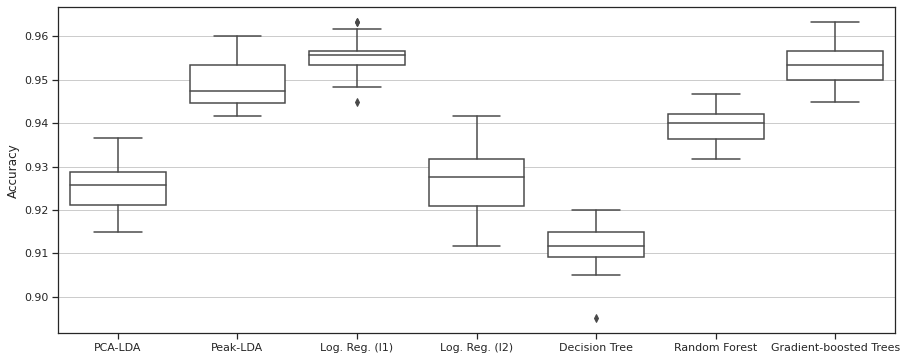

In [ ]:
boxplot_comparison(accs, ylabel="Accuracy", regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

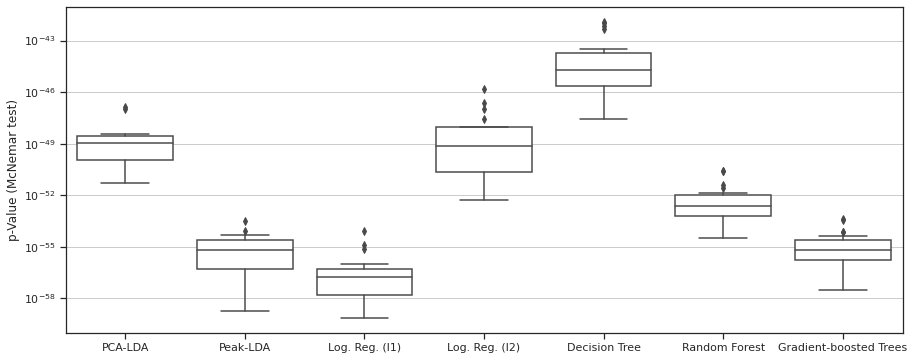

In [ ]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True, regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

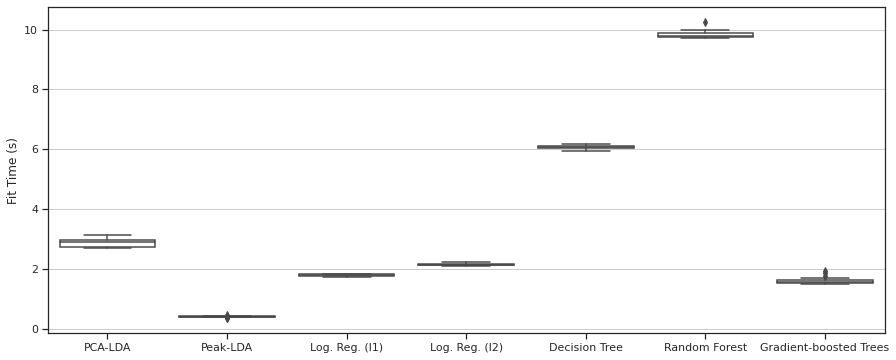

In [ ]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)", regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

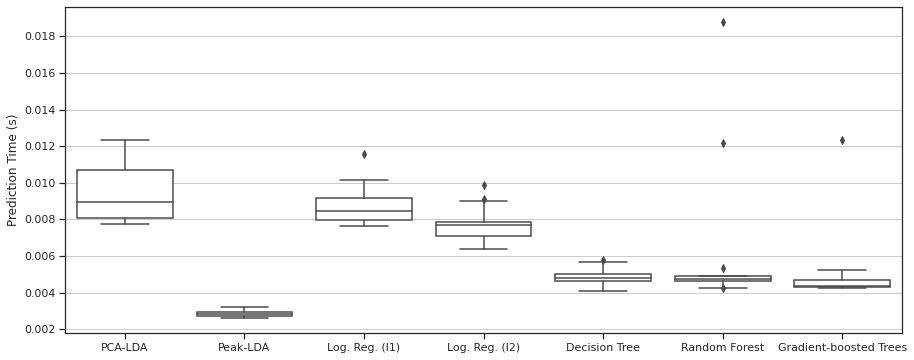

In [ ]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)", regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

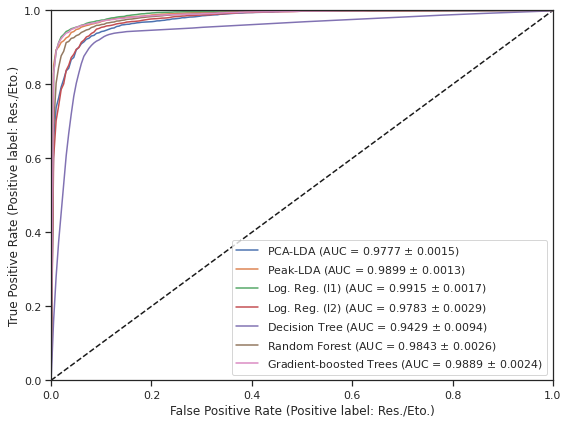

In [ ]:
plot_roc_comparison(rocs, aucs, labels=y_key, regex="PCA|Peak|Log. Reg|Tree|Forest")